In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__)

numpy version:  1.12.1
astropy version:  3.1.dev21607
asdf version:  2.0.0.dev1248
gwcs version:  0.9.dev323
jwst version:  0.9.2a.dev104


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from jwst import datamodels
from jwst.assign_wcs.nirspec import nrs_wcs_set_input

In [4]:
!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg ifu.fits

2018-03-29 12:25:53,852 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2018-03-29 12:25:53,871 - stpipe.assign_wcs - INFO - Step assign_wcs running with args ('ifu.fits',).
2018-03-29 12:26:08,294 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.1258982867002487 deg
2018-03-29 12:26:08,294 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.3318742513656616 deg
2018-03-29 12:26:08,295 - stpipe.assign_wcs - INFO - theta_y correction: 3.965144262312808e-13 deg
2018-03-29 12:26:08,296 - stpipe.assign_wcs - INFO - theta_x correction: 0.0 deg
2018-03-29 12:26:23,157 - stpipe.assign_wcs - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds

In [5]:
im = datamodels.ImageModel('ifu_assign_wcs.fits')
#wcs_00 = nrs_wcs_set_input(im, 0)

### Tilt Correction:

In [6]:
print("ESA Trace file:", fits.getval("./esa/Trace_IFU_Slice_00_SMOS-MOD-G1M-17-5344175105_30192_JLAB88.fits", keyword="THETAY"))
print("Pipeline correction: {0} arcsec".format(3.965144262312808e-13 * 3600))

ESA Trace file: 1.42745193443261e-09
Pipeline correction: 1.4274519344326109e-09 arcsec


### Test 1

For each Trace file:
- Compute the pixel indices (x, y) for values in the SLIT extension that are between -0.5 and 0.5 (within the slit).
- Get the wavelength values for these pixels from the LAMBDA1 extension, the y-slit positions from the SLIT1 extension and teh MSa positions from the MSAY1 and MSAX1 extensions.
- Transfer these (x, y) to full frame coordinates using the FITS WCS in the Trace file.
- Evaluate the pipeline WCS passing these x, y as input to obtain ra, dec, lam from the pipeline code.
- Compute the difference between the ESA and pipeline wavelengths for these x, y pixels.
- Compute the difference in the y_slit position and MSAY positions

In [7]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")

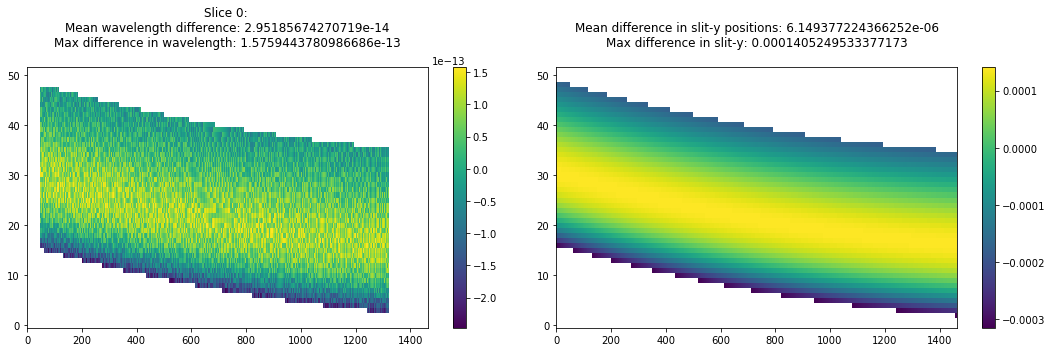

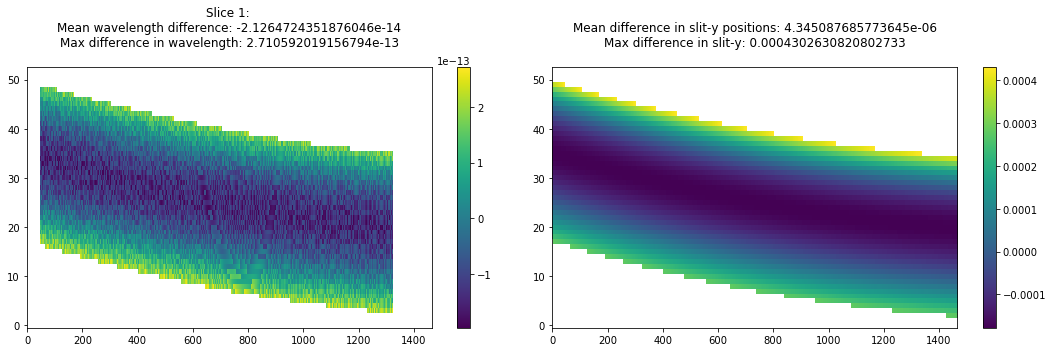

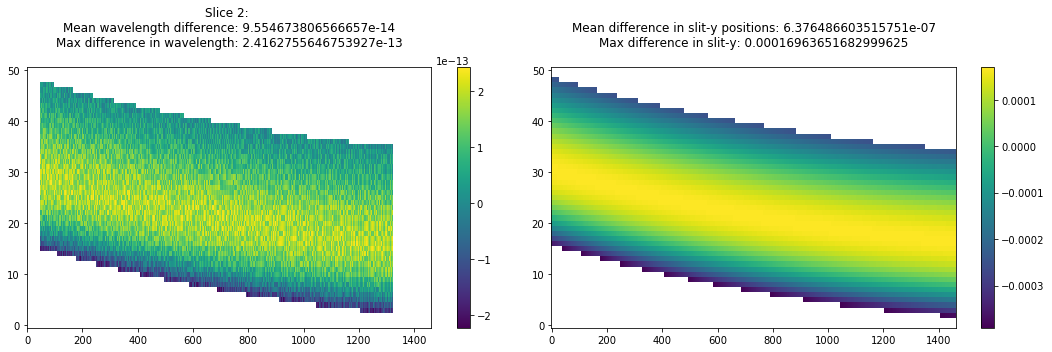

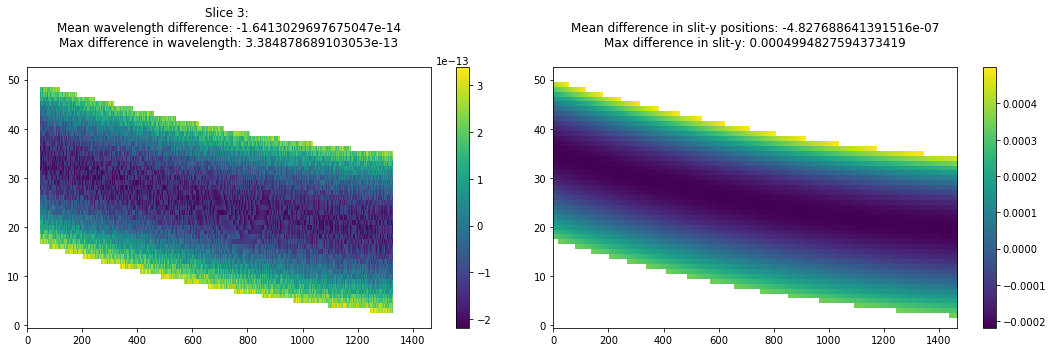

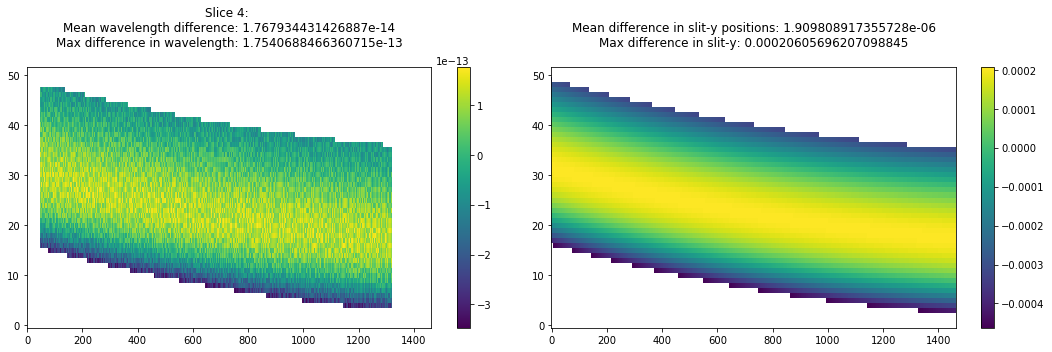

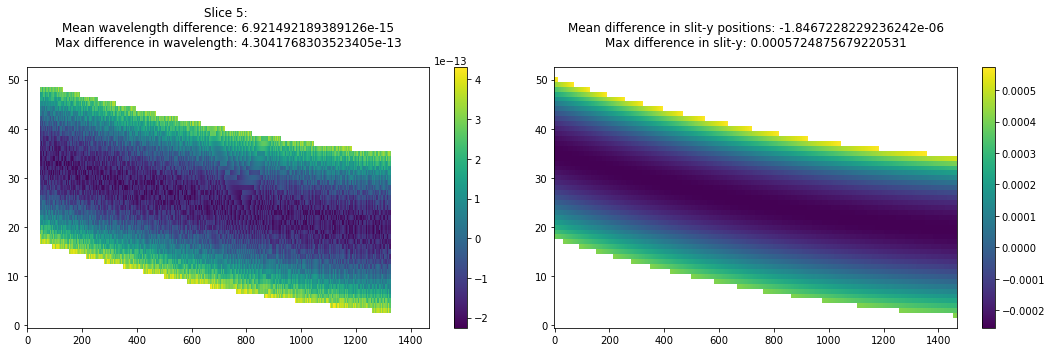

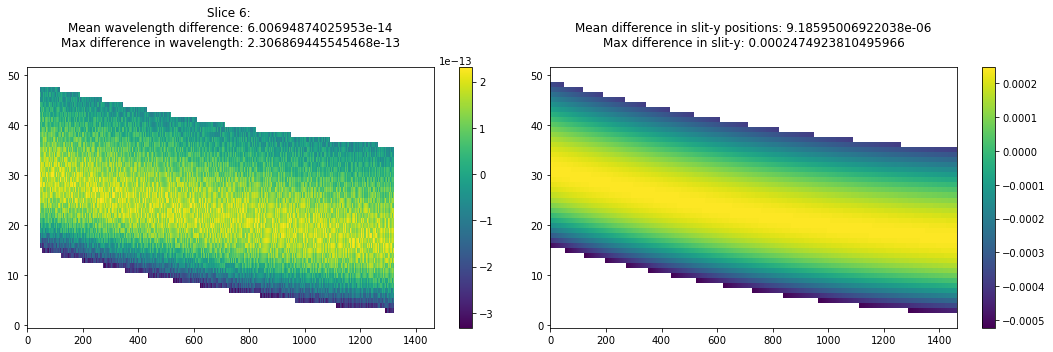

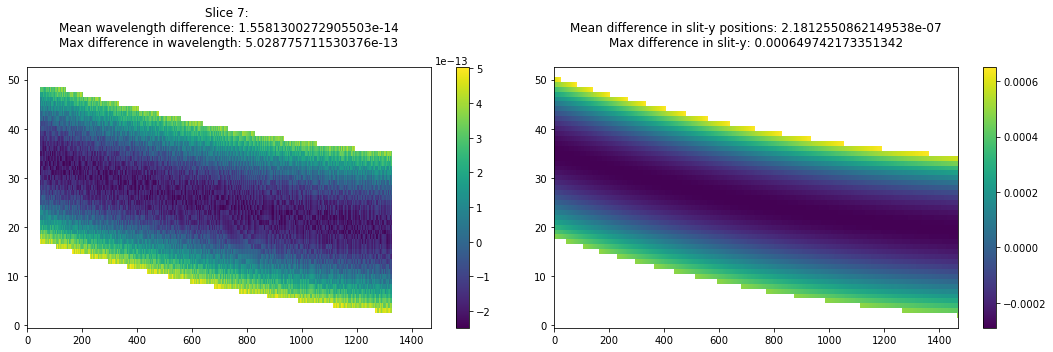

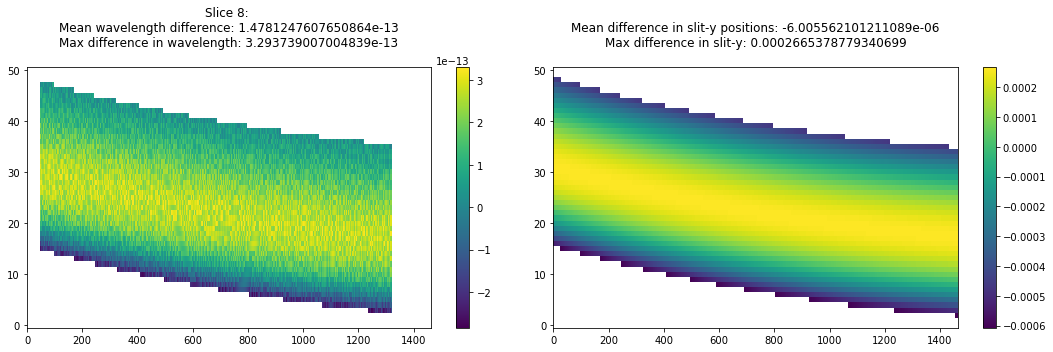

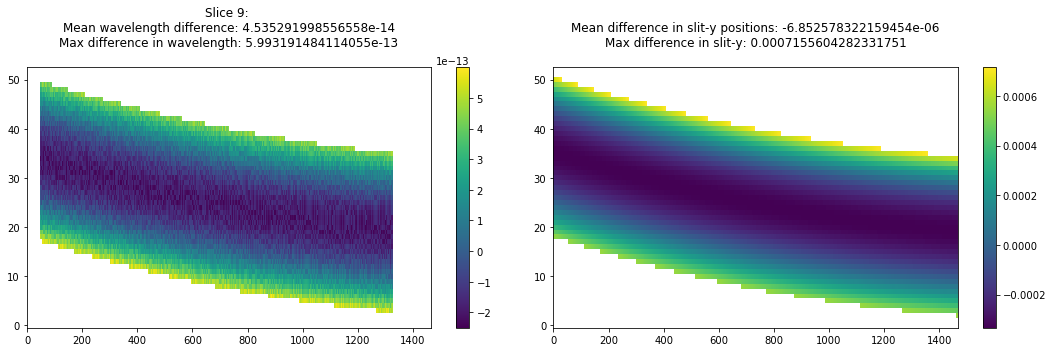

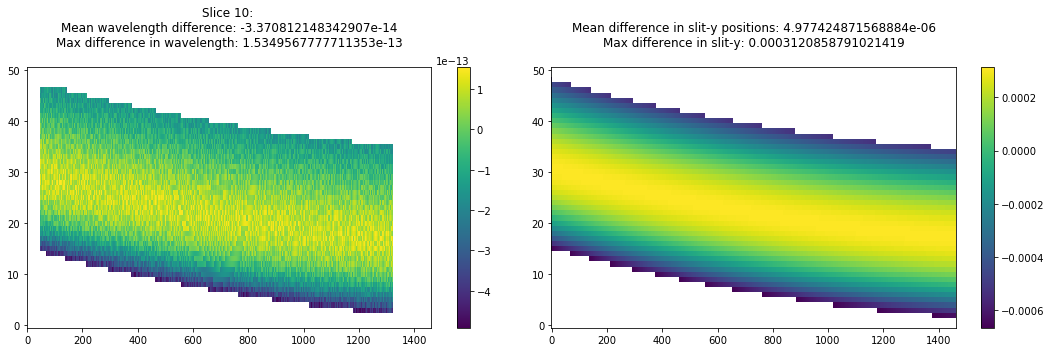

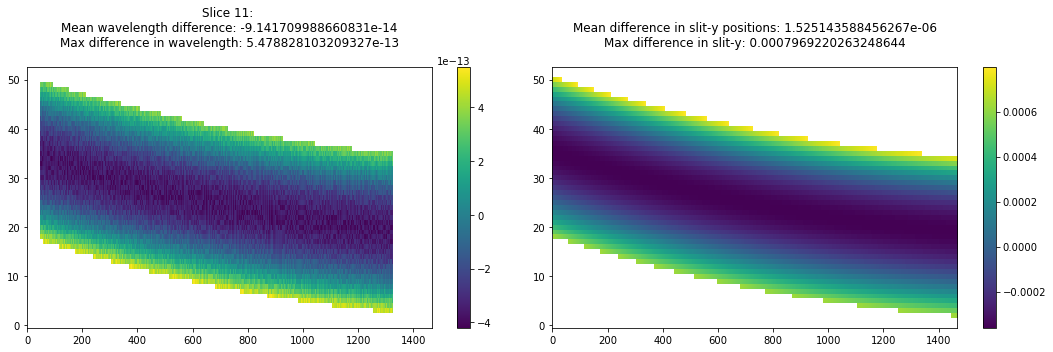

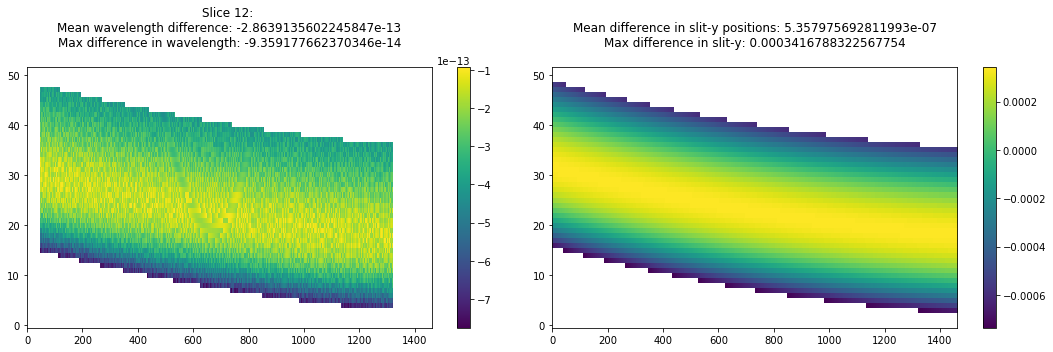

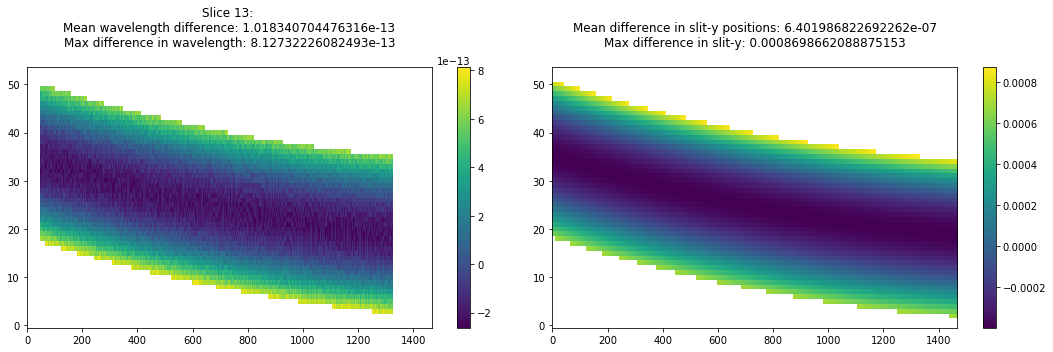

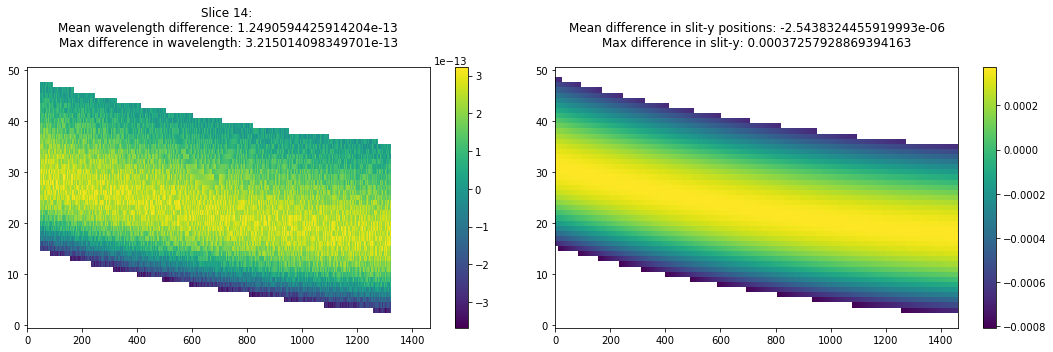

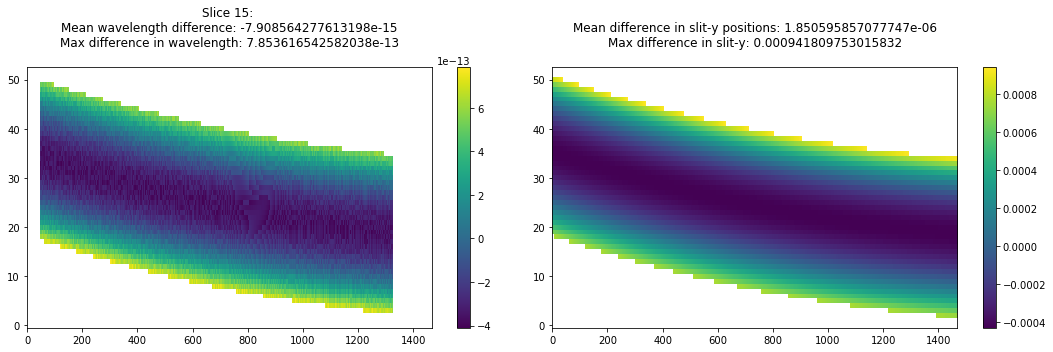

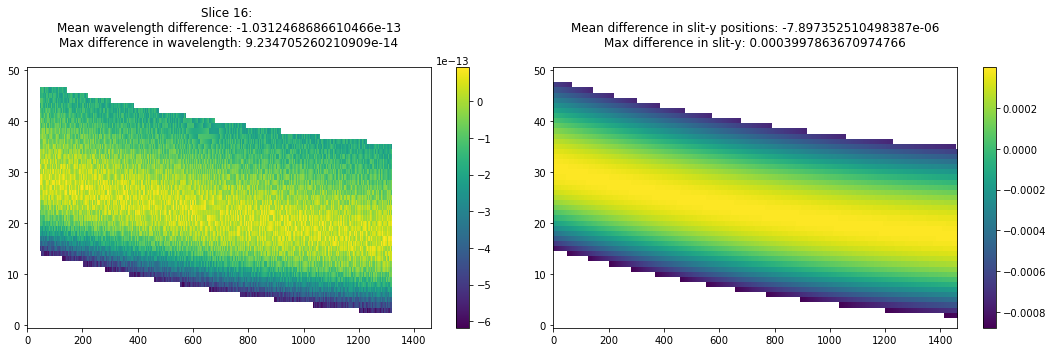

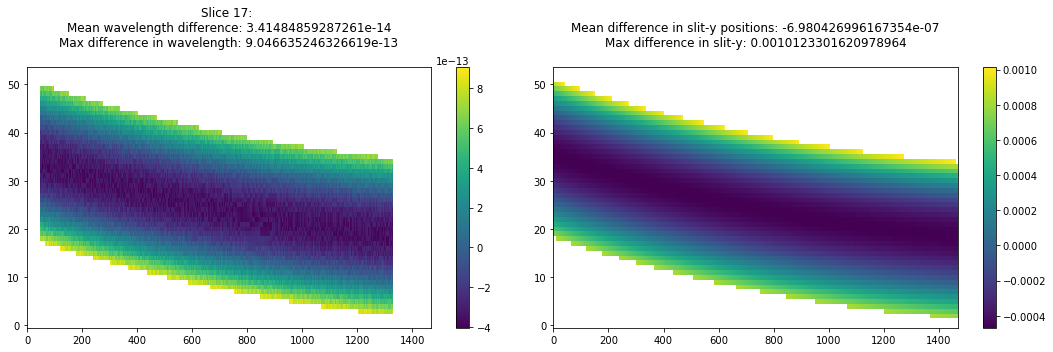

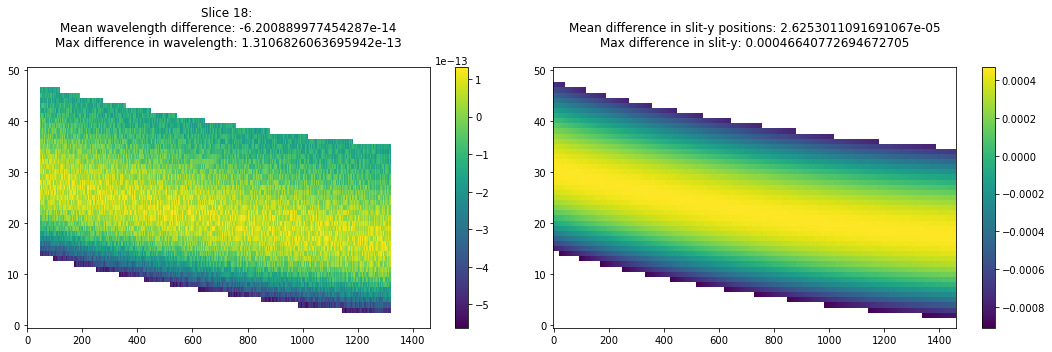

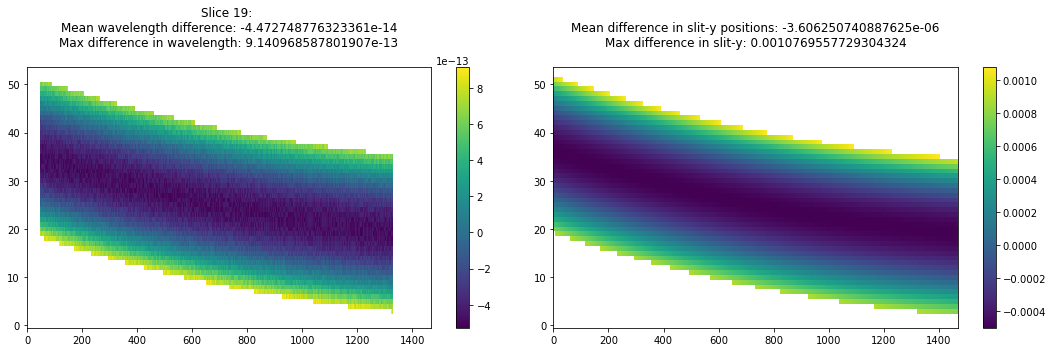

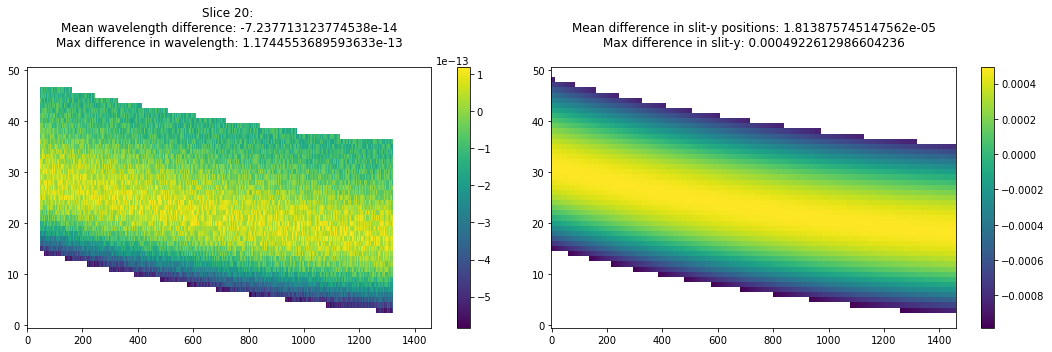

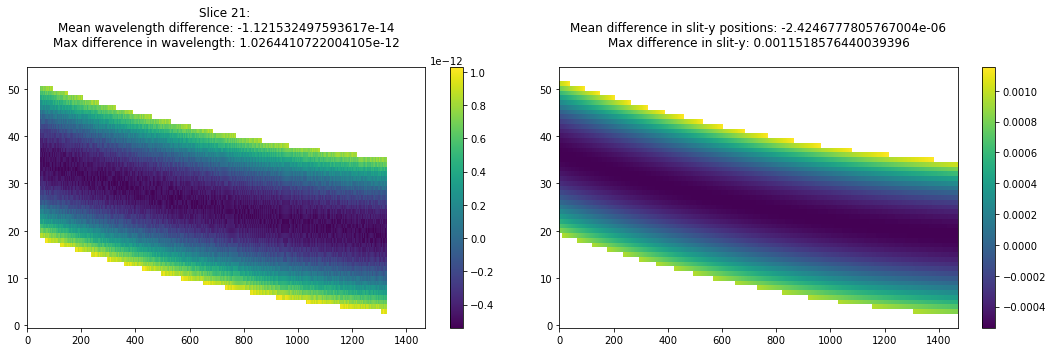

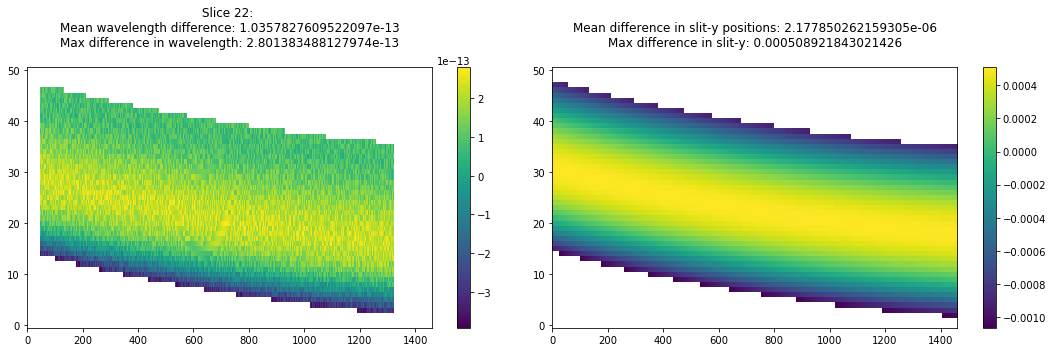

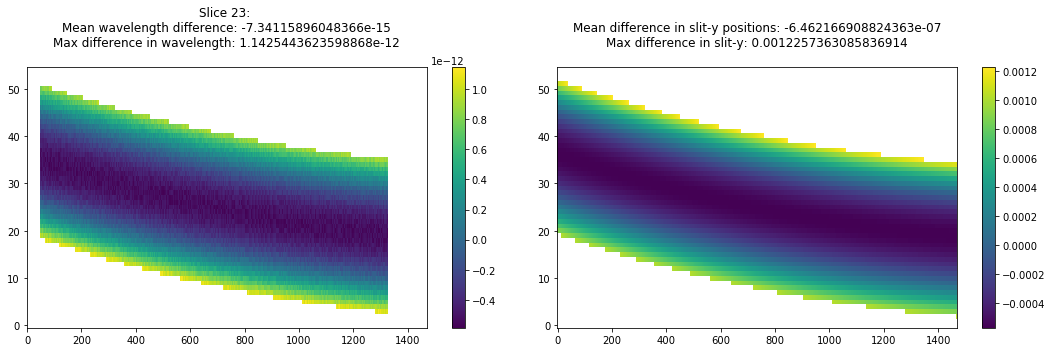

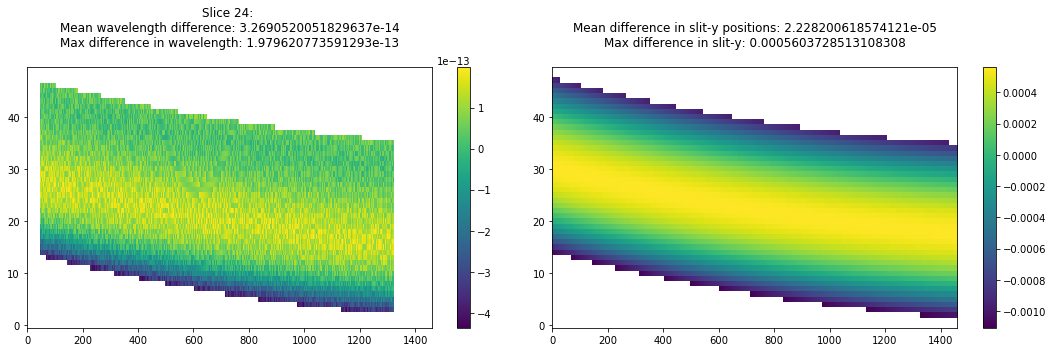

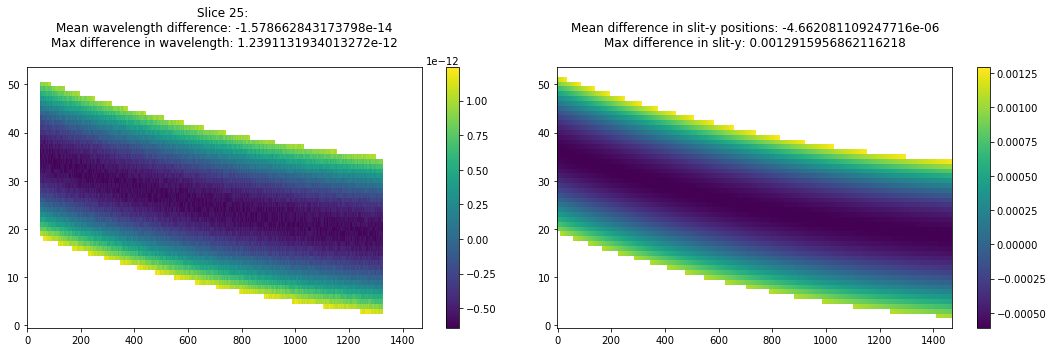

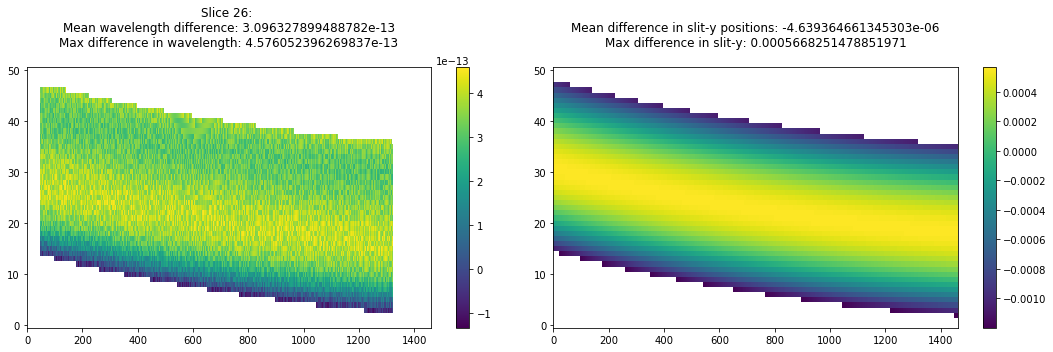

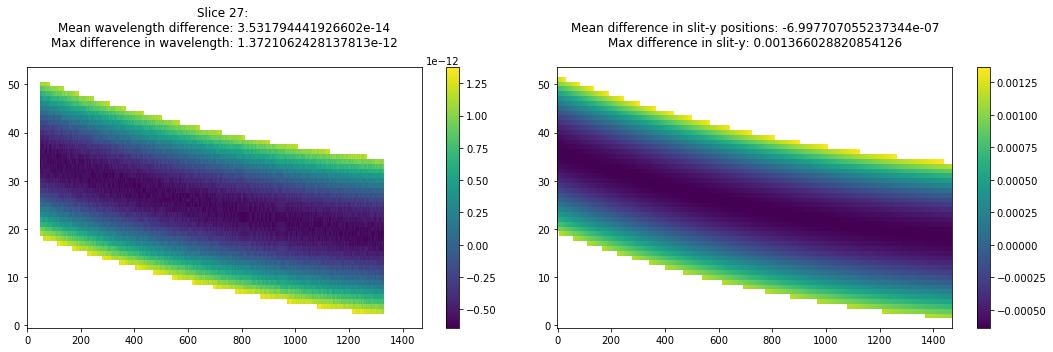

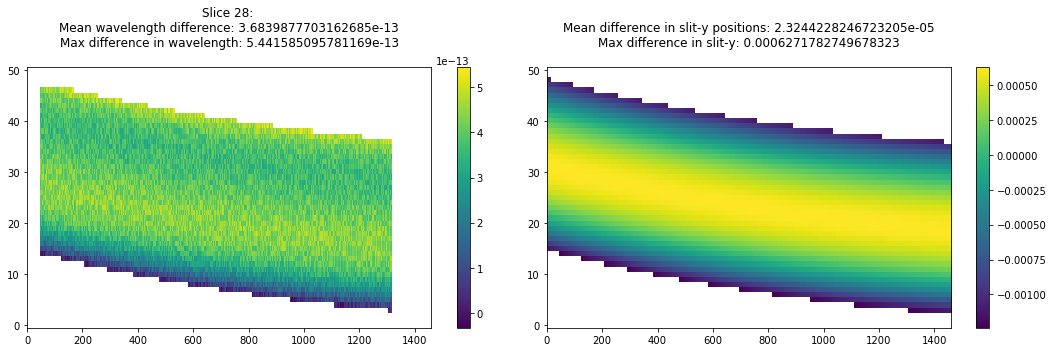

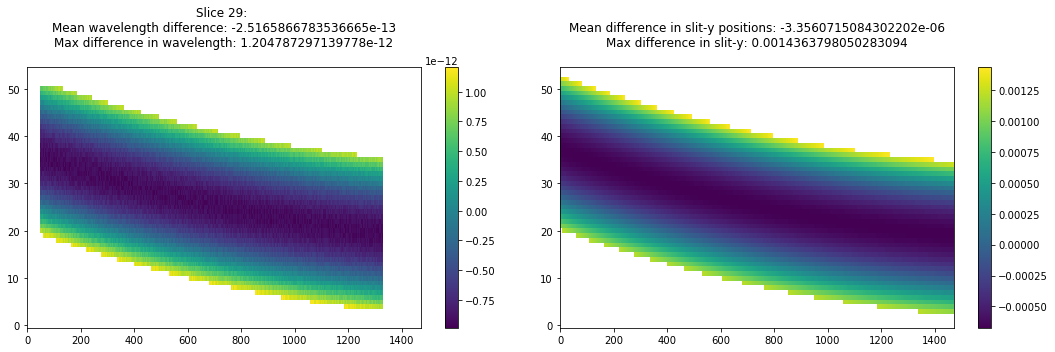

In [11]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr[4].data
    slit1 = tr[5].data
    msay1 = tr[7].data
    pyw = wcs.WCS(tr[4].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x+1, y+1, 1) # +1 for 1-based inputs

    # Get the WCS for this particular slice
    wcs_slice = nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1, y1)
    lam *= 10**-6

    # For pixels where lam == NaN, set the value to -1
    #nanind = np.isnan(lam)
    #lam[nanind] = -1
    #lam1[nanind] = -1
    #oneind = lam1 == -1
    #lam[oneind] = -1
    notnan = ~np.isnan(lam)
    
    # Compute the difference in wavelength
    diff = lam - lam1
    title = "Slice {}: \n".format(slice_id)
    title += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
    title += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))

    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, _ = detector2slit(x1, y1)
    #sy[nanind] = -1
    #sy[oneind] = -1
    #slit1[nanind] = -1
    diffslit = sy - slit1
    # Plot differences and some statistics
    titles = "Mean difference in slit-y positions: {}\n".format(np.mean(diffslit[notnan]))
    titles += "Max difference in slit-y: {}\n".format(np.max(diffslit[notnan]))
    #print ("SLICE {}".format(slice_id))
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diff, aspect='auto')
    plt.title(title)
    plt.colorbar(i1, ax=ax1 )
    ax2 = plt.subplot(1,2,2)
    i2 = ax2.imshow(diffslit, aspect='auto')
    plt.title(titles)
    plt.colorbar(i2, ax=ax2)

    fig.tight_layout()